### 1. Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import pyodbc
import openpyxl
from tabulate import tabulate
import re
from datetime import datetime

### 2. Import data

In [2]:
# Replace 'your_server', 'your_database', 'your_username', and 'your_password' with your actual connection details
server = 'AZ-ODB0\ODBWB'
database = 'OnderzoeksDB_WB'

# Create a connection string
connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

# Establish a connection
connection = pyodbc.connect(connection_string)

# Replace 'your_query' with your SQL query
query = 'SELECT * FROM Regas_Problematiek'

# Execute the query and fetch the data into a Pandas DataFrame
df_og = pd.read_sql(query, connection)

# Close the connection
connection.close()

<>:2: SyntaxWarning: invalid escape sequence '\O'
<>:2: SyntaxWarning: invalid escape sequence '\O'
C:\Users\l.hanen\AppData\Local\Temp\ipykernel_15036\1692472480.py:2: SyntaxWarning: invalid escape sequence '\O'
  server = 'AZ-ODB0\ODBWB'
C:\Users\l.hanen\AppData\Local\Temp\ipykernel_15036\1692472480.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_og = pd.read_sql(query, connection)


### 3. EDA

#### 3.1 Select columns and rows

##### 3.1.1 Columns

In [3]:
# Reorder columns and make copy of df
df = df_og[[#'Casus',
            #'Persoonsnummer',
            'Gemeente',
            'JaarStartCasus',
            'Datum melding',
            'Geboortejaar',
            #'Geboortemaand',
            'Soort melder',
            'Aanwezigheid minderjarige kinderen',
            'Is er sprake van huiselijk geweld?',
            'Is er sprake van agressie / geweld?',
            #'Inhoud melding',
            #'E33 melding',
            'Wijk-GGD',
            'Melding hoe ontvangen',
            'Vermoeden van problematiek',
            'Eerste advies',

            # EINDE MELDINGSFASE

            #'Hoofdprobleem (1 antwoord mogelijk)',
            #'Subproblemen (meerdere antwoorden mogelijk)',
            #'Besproken op datum',
            #'Inhoud',
            #'Contact met',
            #'Soort contact',
            'Datum',
            'Medewerker',

            # EINDE TRAJECT/ONDERZOEKSFASE

            'Datum afsluiting',
            #'Reden afsluiting',
            #'Voortgang proces door',
            #'Bijzonderheden',
            #'Soort instelling verwijzing',
            
            # EINDE SLUITINGSFASE

            'DubbelRecord']].copy() # All hashed columns are not needed

##### 3.1.2 Rows

In [4]:
# Drop all rows that have not been closed yet, without notification dates and with condition 'Onverzekerd'
df.dropna(subset=['Datum afsluiting'], inplace=True)
df.dropna(subset=['Datum melding'], inplace=True)
df.drop(df[df['Vermoeden van problematiek'] == 'Onverzekerde zorg GGD GHOR NL'].index, inplace=True)

#### 3.2 Transform column Dtypes

In [5]:
def convert_to_bool(column):
    bool_mapping = {'y': True, 'Ja': True, 'n': False, 'Nee': False}
    return bool_mapping.get(column, np.NaN)

columns_to_convert = ['Aanwezigheid minderjarige kinderen', 
                      'Is er sprake van huiselijk geweld?', 
                      'Is er sprake van agressie / geweld?', 
                      #'E33 melding', 
                      'Wijk-GGD', 
                      'DubbelRecord']

for col in columns_to_convert:
    df[col] = df[col].apply(convert_to_bool)

In [6]:
# Function to convert string to list of strings
def string_to_list(string):
    # Return empty list if no string is provided
    if not string:
        return []
    # Split by comma's and add to list
    else:
        list_of_strings = string.split(', ')
        list_of_strings = [string for string in list_of_strings]
        return list_of_strings

# Overwrite the column with the transformed version
df['Vermoeden van problematiek'] = df['Vermoeden van problematiek'].apply(string_to_list)

In [7]:
convert_dict = {#'Casus': object,
                #'Persoonsnummer': object,
                
                'Geboortejaar': 'category',
                #'Geboortemaand': 'category',
                'JaarStartCasus': 'category',
                
                'Gemeente': 'category',
                'Soort melder': 'category',
                'Melding hoe ontvangen': 'category',
                'Eerste advies': 'category',
                'Medewerker': 'category',
                #'Hoofdprobleem (1 antwoord mogelijk)': 'category',
                #'Reden afsluiting': 'category',
                #'Voortgang proces door': 'category',
                #'Soort instelling verwijzing': 'category',

                'Aanwezigheid minderjarige kinderen': 'boolean',
                'Is er sprake van huiselijk geweld?': 'boolean',
                'Is er sprake van agressie / geweld?': 'boolean',
                #'E33 melding': 'boolean',
                'Wijk-GGD': 'boolean',
                'DubbelRecord': 'boolean'
                }

df = df.astype(convert_dict)
df['Datum afsluiting'] = pd.to_datetime(df["Datum afsluiting"])
df['Datum melding'] = pd.to_datetime(df["Datum melding"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5674 entries, 0 to 10080
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Gemeente                             5657 non-null   category      
 1   JaarStartCasus                       5674 non-null   category      
 2   Datum melding                        5674 non-null   datetime64[ns]
 3   Geboortejaar                         5674 non-null   category      
 4   Soort melder                         5674 non-null   category      
 5   Aanwezigheid minderjarige kinderen   1507 non-null   boolean       
 6   Is er sprake van huiselijk geweld?   1312 non-null   boolean       
 7   Is er sprake van agressie / geweld?  1428 non-null   boolean       
 8   Wijk-GGD                             3197 non-null   boolean       
 9   Melding hoe ontvangen                5674 non-null   category      
 10  Vermoeden van pr

#### 3.3 Inspect categorical columns

In [8]:
# Initialize an empty dictionary to store unique values and value counts for specific columns
unique_values_counts_dict = {}
specific_columns = ['Gemeente',
                    'Soort melder',
                    'Vermoeden van problematiek',
                    #'Voortgang proces door',
                    'Eerste advies',
                    #'Reden afsluiting',
                    'Melding hoe ontvangen',
                    'Aanwezigheid minderjarige kinderen',
                    'Is er sprake van huiselijk geweld?',
                    'Is er sprake van agressie / geweld?',
                    #'Contact met',
                    #'Soort contact',
                    'Medewerker',
                    #'Hoofdprobleem (1 antwoord mogelijk)',
                    #'Subproblemen (meerdere antwoorden mogelijk)',
                    'Wijk-GGD',
                    #'Soort instelling verwijzing',
                    #'E33 melding',
                    'DubbelRecord']

#### 3.4 Missing data analysis

In [9]:
# Check for missing values
missing_values = df.isna()

# Count missing values in each column
missing_counts = missing_values.sum()

# Calculate percentage of missing values in each column
missing_percentages = (missing_values.mean() * 100).round(2)

# Create a new DataFrame from missing_counts and missing_percentages
missing_data_summary = pd.DataFrame({'Missing Counts': missing_counts, 'Missing Percentages': missing_percentages})

missing_data_summary

,Missing Counts,Missing Percentages
Gemeente,17,0.30
JaarStartCasus,0,0.00
Datum melding,0,0.00
Geboortejaar,0,0.00
Soort melder,0,0.00
Aanwezigheid minderjarige kinderen,4167,73.44
Is er sprake van huiselijk geweld?,4362,76.88
Is er sprake van agressie / geweld?,4246,74.83
Wijk-GGD,2477,43.66
Melding hoe ontvangen,0,0.00


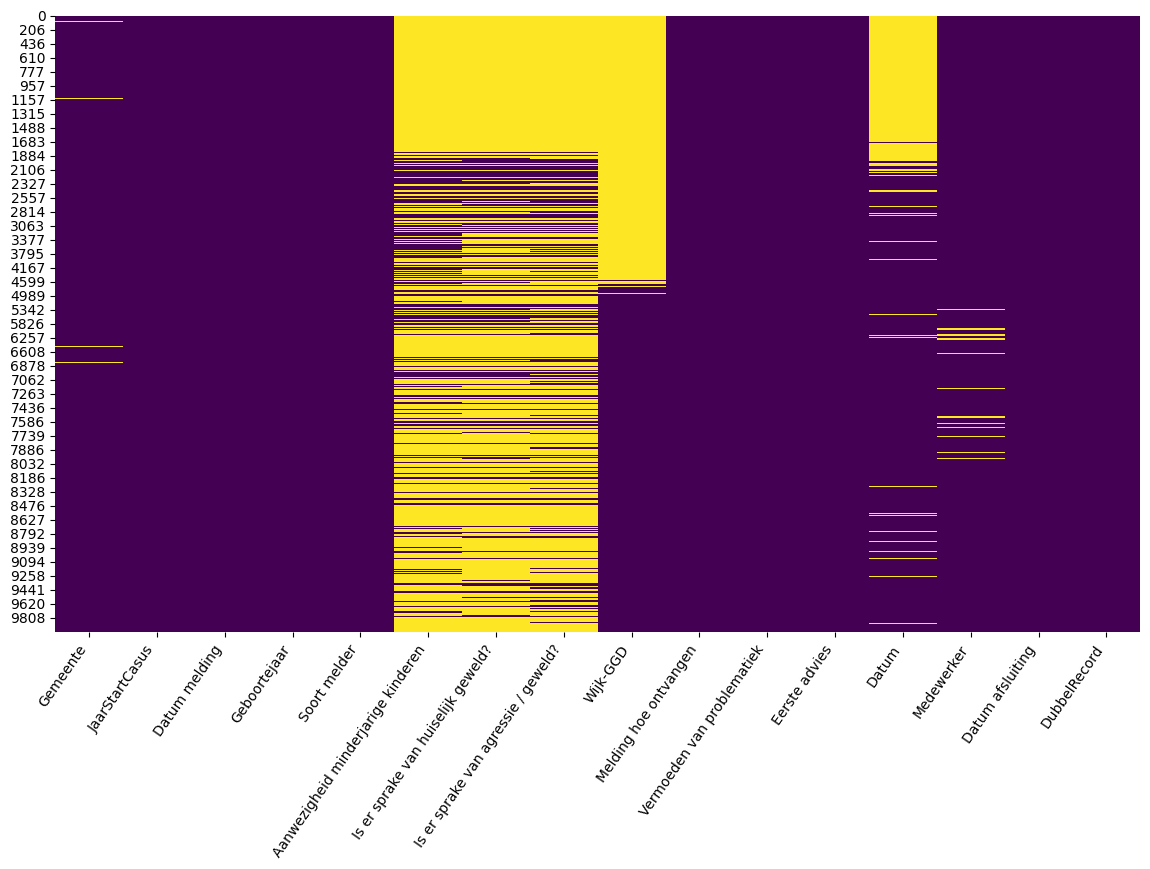

In [10]:
# Visualize missingness pattern with a heatmap
plt.figure(figsize=(14, 8))
heatmap = sns.heatmap(df.isnull(), cmap='viridis', cbar=False)

# Rotate x-labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=55, ha='right')

plt.savefig('../visualizations/eda_png/missing_heatmap.png', bbox_inches='tight', transparent=True)
plt.show()

#### 3.5 Visualize number of instances

In [11]:
# Drop all rows that have not been closed yet
df.dropna(subset=['Datum afsluiting'], inplace=True)
df.dropna(subset=['Datum melding'], inplace=True)
df.drop(df[df['Vermoeden van problematiek'] == 'Onverzekerde zorg GGD GHOR NL'].index, inplace=True)
df['Month'] = df['Datum melding'].dt.to_period('M')
df['Quarter'] = df['Datum melding'].dt.to_period('Q')

C:\Users\l.hanen\AppData\Local\Temp\ipykernel_15036\1395192650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interventionists = df.groupby(['Medewerker', 'Quarter']).size().reset_index(name='Count')


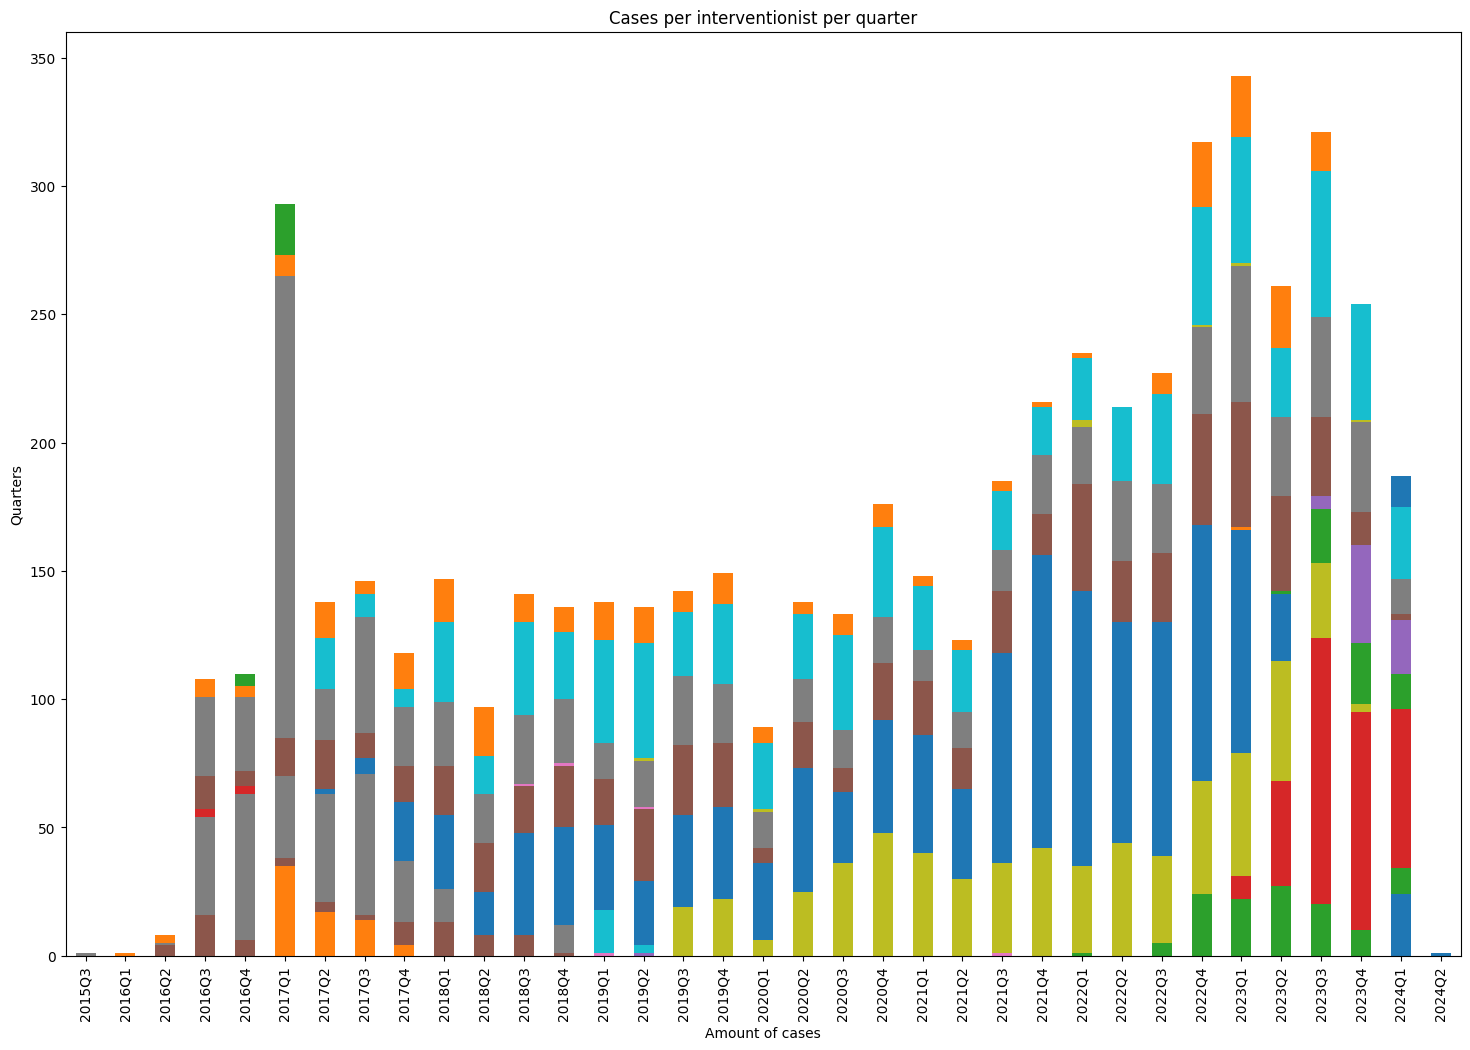

In [12]:
# Storing the amount of cases per interventionist per quarter
interventionists = df.groupby(['Medewerker', 'Quarter']).size().reset_index(name='Count')

# Pivot the data to create a suitable format for plotting
pivot_interventionists = interventionists.pivot(index='Quarter', columns='Medewerker', values='Count')

# Create a stacked bar chart
pivot_interventionists.plot(kind='bar', stacked=True, figsize=(18, 12), legend=False)

# Customize the plot (optional)
plt.title("Cases per interventionist per quarter")
plt.xlabel("Amount of cases")
plt.ylabel("Quarters")

# Show and save the plot
plt.savefig('../visualizations/eda_png/cases_per_interventionist_q.png', bbox_inches='tight', transparent=True)
plt.show()

C:\Users\l.hanen\AppData\Local\Temp\ipykernel_15036\3257651448.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interventionists = df.groupby(['Medewerker', 'Month']).size().reset_index(name='Count')


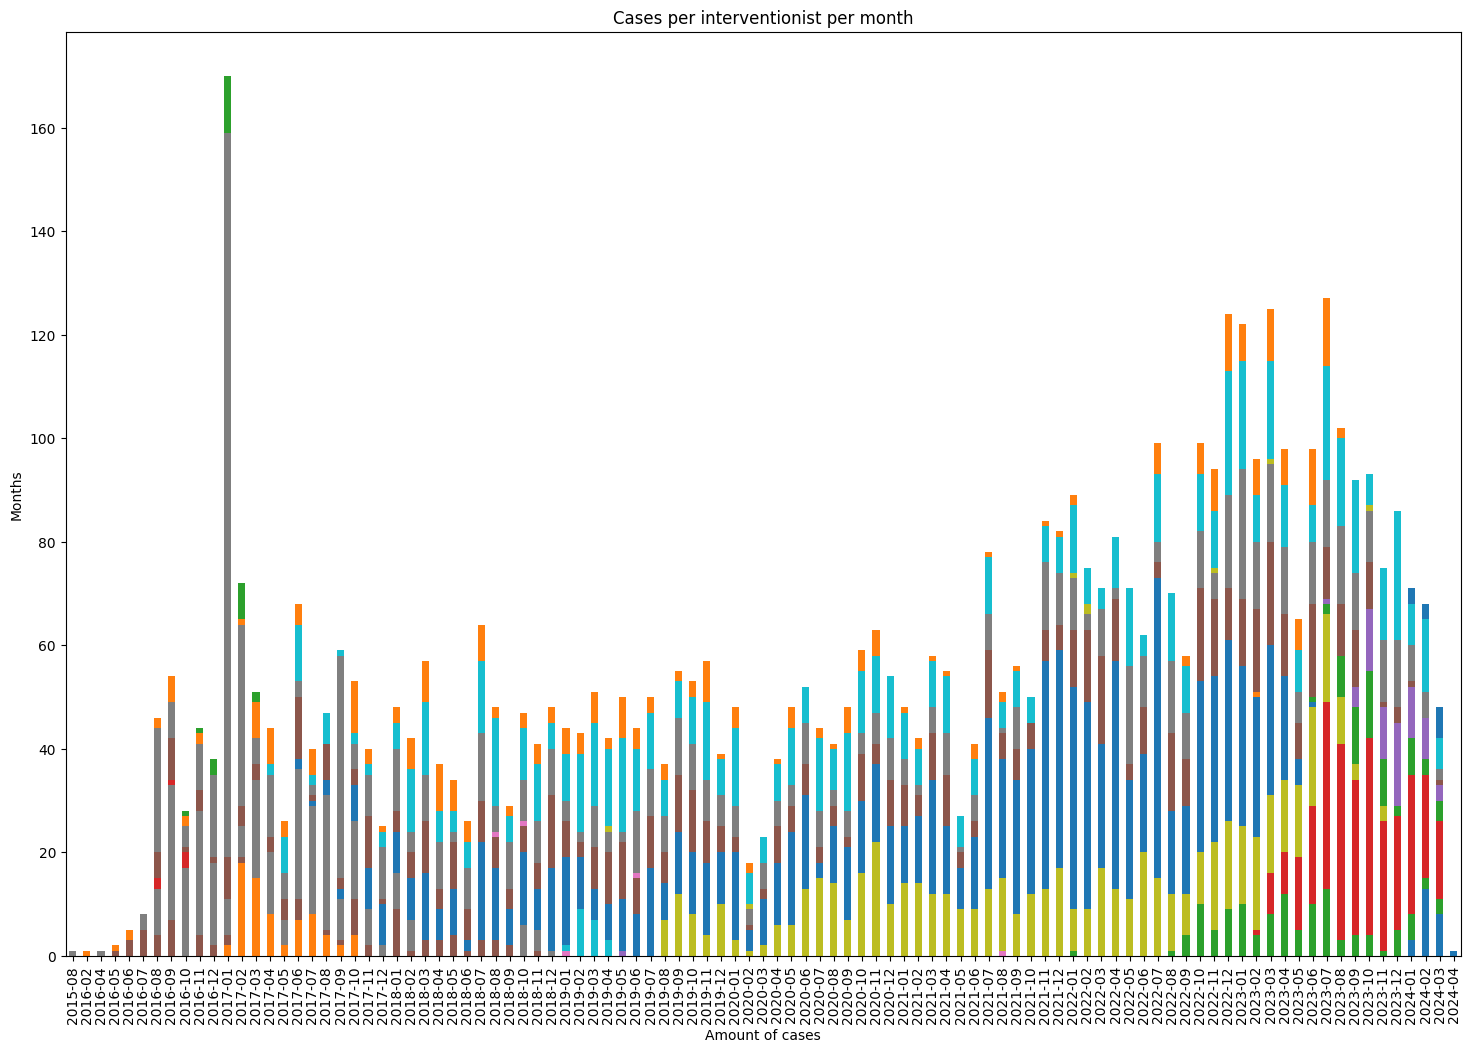

In [14]:
# Storing the amount of cases per interventionist per quarter
interventionists = df.groupby(['Medewerker', 'Month']).size().reset_index(name='Count')

# Pivot the data to create a suitable format for plotting
pivot_interventionists = interventionists.pivot(index='Month', columns='Medewerker', values='Count')

# Create a stacked bar chart
pivot_interventionists.plot(kind='bar', stacked=True, figsize=(18, 12), legend=False)

# Customize the plot (optional)
plt.title("Cases per interventionist per month")
plt.xlabel("Amount of cases")
plt.ylabel("Months")

# Show and save the plot
plt.savefig('../visualizations/eda_png/cases_per_interventionist_m.png', bbox_inches='tight', transparent=True)
plt.show()

#### 3.5 Visualize number of interventions until case closure

In [15]:
# Count commas in the 'Datum' column and add a new column 'Comma_Count'
df['No_interventions'] = df['Datum'].apply(lambda x: 0 if pd.isna(x) else 1 if ',' not in x else x.count(',') + 1)

# Store frequencies
No_interventions_frequencies = df['No_interventions'].value_counts().sort_index()

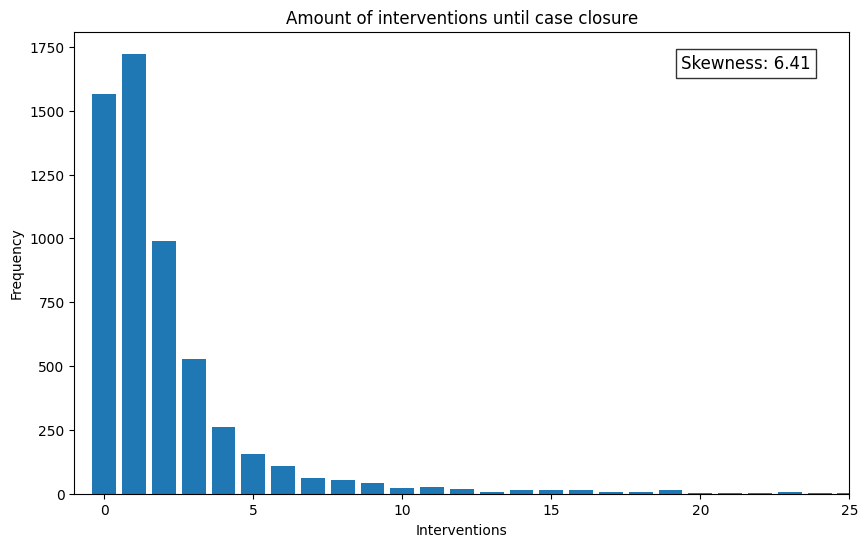

In [16]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(No_interventions_frequencies.index, No_interventions_frequencies)

# Add skewness to the plot
plt.text(0.95, 0.95, f'Skewness: {skew(df['No_interventions']):.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.xlabel('Interventions')
plt.ylabel('Frequency')
plt.title('Amount of interventions until case closure')
ax = plt.gca()
ax.set_xlim([-1, 25])

# Show the plot
plt.savefig('../visualizations/eda_png/interventions.png', bbox_inches='tight', transparent=True)
plt.show()

#### 3.6 Visualize number of days until case closure

In [17]:
# Function to return the last date if exists
def get_last_date(dates):
    if pd.isnull(dates):
        return np.nan
    date_list = dates.split(',')
    date_list = [pd.to_datetime(date) for date in date_list if date]
    if not date_list:
        return np.nan
    return max(date_list)

# Apply the function to the 'Datum' column
df['LastDate'] = df['Datum'].apply(get_last_date)

# Calculate difference in days
df['No_days'] = (df['LastDate'] - df['Datum melding']).dt.days

# Remove the 'LastDate' column from the DataFrame
df.drop(columns=['LastDate'], inplace=True)

# Store frequencies
No_days_frequencies = df['No_days'].value_counts().sort_index()

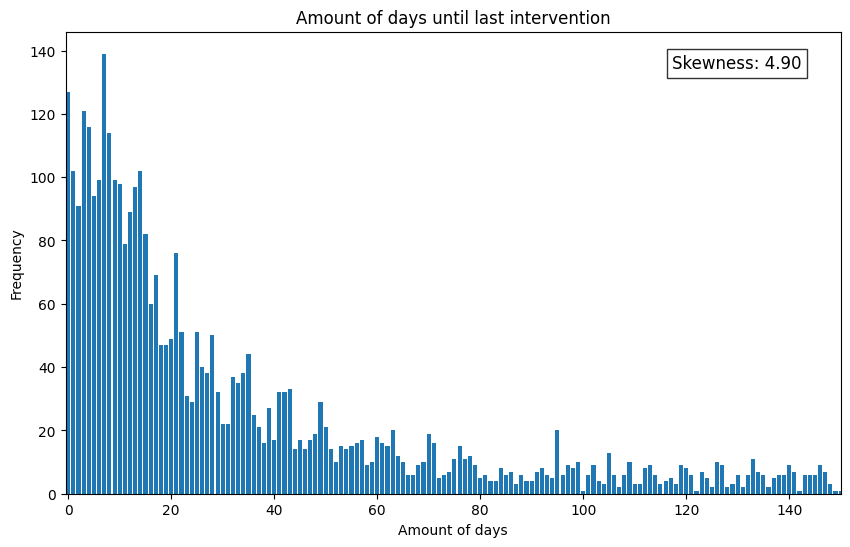

In [19]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(No_days_frequencies.index, No_days_frequencies)

# Add skewness to the plot
plt.text(0.95, 0.95, f'Skewness: {skew(df['No_days'], nan_policy='omit'):.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.xlabel('Amount of days')
plt.ylabel('Frequency')
plt.title('Amount of days until last intervention')
ax = plt.gca()
ax.set_xlim([-0.5, 150])

# Show the plot
plt.savefig('../visualizations/eda_png/days.png', bbox_inches='tight', transparent=True)
plt.show()

#### 3.7 Relationship between days (3.5) and interventions (3.6) until case closure

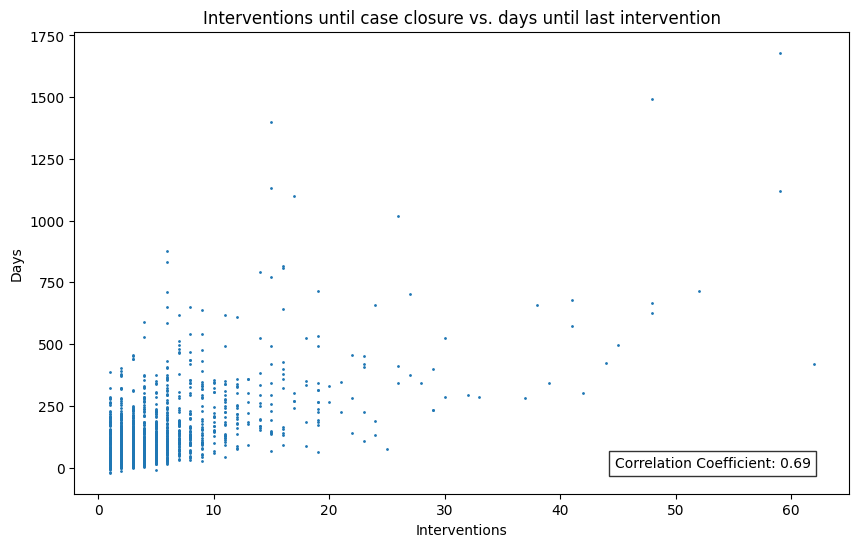

In [20]:
# Calculate correlation coefficient
correlation_coefficient = df['No_interventions'].corr(df['No_days'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['No_interventions'], df['No_days'], s=1)

# Add labels and title
plt.xlabel('Interventions')
plt.ylabel('Days')
plt.title('Interventions until case closure vs. days until last intervention')

# Add correlation coefficient to the plot
plt.text(0.95, 0.05, f'Correlation Coefficient: {correlation_coefficient:.2f}', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Show the plot
plt.savefig('../visualizations/eda_png/days_interventions.png', bbox_inches='tight', transparent=True)
plt.show()

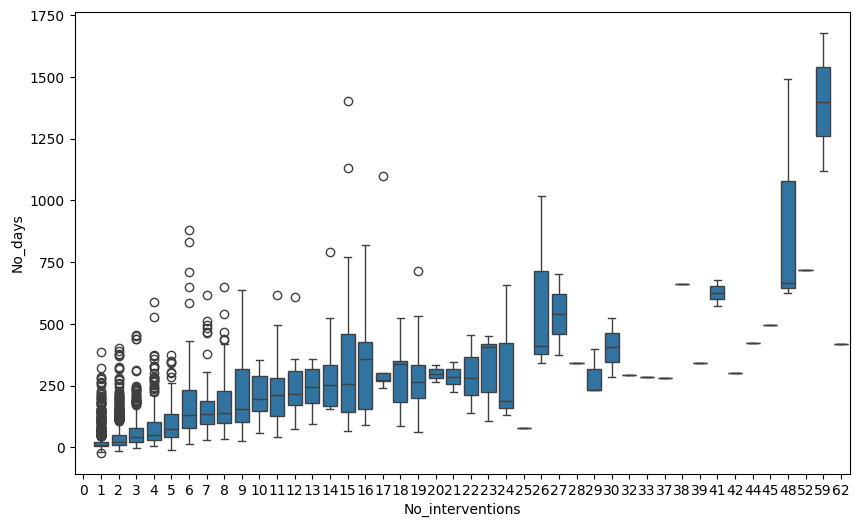

In [21]:
data = pd.concat([df['No_interventions'], df['No_days']], axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x="No_interventions", y="No_days", data=data)
plt.savefig('../visualizations/eda_png/box_days_interventions.png', bbox_inches='tight', transparent=True)
plt.show()

In [22]:
#plt.figure(figsize=(18, 12))
#sns.swarmplot(data = data, x='No_interventions', y='No_days')

#### 3.8 Explore features (and relationships)

##### 3.8.1 Features individually

In [23]:
# Function to bar plot a variable and its frequencies
def barplot_variable(df):
    for column in df.columns:
        dtype = df[column].dtype
        if dtype == 'category' or dtype == 'boolean' or dtype == 'datetime64[ns]':
            frequencies = df[column].value_counts(dropna=False).sort_index()
            plt.figure(figsize=(10, 6))
            plt.bar(frequencies.index.astype(str), frequencies)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.xticks(rotation=55, ha='right')
            filename = re.sub(r'[^a-zA-Z\s]', '', column).replace(' ', '_')
            plt.savefig(f'../visualizations/eda_png/individuals_png/{filename}.png', bbox_inches='tight')
            plt.close()
        elif dtype == 'object':
            frequencies = df[column].explode().value_counts().sort_index()
            plt.figure(figsize=(10, 6))
            plt.bar(frequencies.index.astype(str), frequencies)
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.xticks(rotation=55, ha='right')
            filename = re.sub(r'[^a-zA-Z\s]', '', column).replace(' ', '_')
            plt.savefig(f'../visualizations/eda_png/individuals_png/{filename}.png', bbox_inches='tight')
            plt.close()

In [24]:
barplot_variable(df)

##### 3.8.2 Feature relationships within and across Dtypes

In [25]:
# Function to bar plot a variable and its frequencies
def eda_cross_types(df):
    continuous = ['int64', 'float64', 'datetime64[ns]']
    nominal = ['category', 'boolean']
    for column_x in df.columns:
        for column_y in df.columns:
            if column_x != column_y:
                # Bar plot when both columns are nominal
                if df[column_x].dtype in nominal and df[column_y].dtype in nominal:
                    cross_tab = pd.crosstab(df[column_x], df[column_y], dropna=False)
                    ax = cross_tab.plot(kind='bar', stacked=True)
                    ax.set_xlabel(column_x)
                    ax.set_ylabel('Frequency')
                    plt.xticks(rotation=55, ha='right')
                    ax.set_title(f'{column_x} vs {column_y}')
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    filename = re.sub(r'[^a-zA-Z\s]', '', f'{column_x} vs {column_y}').replace(' ', '_')
                    plt.savefig(f'../visualizations/eda_png/relations_png/{re.sub(r'[^a-zA-Z\s]', '', column_x)}_png/{filename}.png', bbox_inches='tight')
                    plt.close()

                # Scatter plot when both columns are continuous
                elif df[column_x].dtype in continuous and df[column_y].dtype in continuous:
                    plt.figure(figsize=(10, 6))
                    plt.scatter(df[column_x], df[column_y])
                    plt.xlabel(column_x)
                    plt.ylabel(column_y)
                    plt.xticks(rotation=55, ha='right')
                    plt.title(f'{column_x} vs {column_y}')
                    filename = re.sub(r'[^a-zA-Z\s]', '', f'{column_x} vs {column_y}').replace(' ', '_')
                    plt.savefig(f'../visualizations/eda_png/relations_png/{re.sub(r'[^a-zA-Z\s]', "", column_x)}_png/{filename}.png', bbox_inches='tight')
                    plt.close()

                # Box plot when first column is nominal and second column is continuous
                elif df[column_x].dtype in nominal and df[column_y].dtype in continuous:
                    plt.figure(figsize=(10, 6))
                    sns.boxplot(x=column_x, y=column_y, data=df.astype({column_x: 'category'}))
                    plt.xlabel(column_x)
                    plt.ylabel(column_y)
                    plt.xticks(rotation=55, ha='right')
                    plt.title(f'{column_x} vs {column_y}')
                    filename = re.sub(r'[^a-zA-Z\s]', '', f'{column_x} vs {column_y}').replace(' ', '_')
                    plt.savefig(f'../visualizations/eda_png/relations_png/{re.sub(r"[^a-zA-Z\s]", "", column_x)}_png/{filename}.png', bbox_inches='tight')
                    plt.close()

                # Box plot when first column is continuous and second column is nominal
                elif df[column_x].dtype in continuous and df[column_y].dtype in nominal:
                    plt.figure(figsize=(10, 6))
                    sns.boxplot(x=column_y, y=column_x, data=df.astype({column_y: 'category'}))
                    plt.xlabel(column_y)
                    plt.ylabel(column_x)
                    plt.xticks(rotation=55, ha='right')
                    plt.title(f'{column_x} vs {column_y}')
                    filename = re.sub(r'[^a-zA-Z\s]', '', f'{column_x} vs {column_y}').replace(' ', '_')
                    plt.savefig(f'../visualizations/eda_png/relations_png/{re.sub(r"[^a-zA-Z\s]", "", column_x)}_png/{filename}.png', bbox_inches='tight')
                    plt.close()

In [26]:
eda_cross_types(df)

#### 3.9 Sample-wise exploration

In [27]:
# Extract n highest rows based on respectively days and interventions
n = 20
top_cases_days = df.nlargest(n, 'No_days')
top_cases_interventions = df.nlargest(n, 'No_interventions')

# Merge the two DataFrames vertically with an outer join
intense_cases = pd.concat([top_cases_days, top_cases_interventions], axis=0, join='outer')

# Save to .xlsx file
intense_cases.to_excel('../visualizations/eda_xlsx/intense_cases.xlsx', index=False)

### 4. train-dev-test-OoS split

In [28]:
# Specify date splits
X = pd.to_datetime('2023-01-01')
Y = pd.to_datetime('2022-01-01')
Z = pd.to_datetime('2021-01-01')

# Split
train = df[df['Datum melding'] < Z]
dev = df[(df['Datum melding'] < Y) & (df['Datum melding'] >= Z)]
test = df[(df['Datum melding'] < X) & (df['Datum melding'] >= Y)]
oos = df[df['Datum melding'] >= X]

# Calculate the number of months in each split
num_months_train = (Z.year - train['Datum melding'].min().year) * 12 + Z.month - train['Datum melding'].min().month
num_months_dev = (Y.year - dev['Datum melding'].min().year) * 12 + Y.month - dev['Datum melding'].min().month
num_months_test = (X.year - test['Datum melding'].min().year) * 12 + X.month - test['Datum melding'].min().month
num_months_oos = (df['Datum melding'].max().year - X.year) * 12 + df['Datum melding'].max().month - X.month

# Identify 'Medewerker' instances in each split
train_interventionists = set(train['Medewerker'].unique())
dev_interventionists = set(dev['Medewerker'].unique())
test_interventionists = set(test['Medewerker'].unique())
oos_interventionists = set(oos['Medewerker'].unique())

# Identify unseen 'Medewerker' instances in each split
train_unseen_interventionists = train_interventionists
dev_unseen_interventionists = dev_interventionists - train_interventionists
test_unseen_interventionists = test_interventionists - (train_interventionists | dev_interventionists)
oos_unseen_interventionists = oos_interventionists - (train_interventionists | dev_interventionists | test_interventionists)

# Calculate the percentage of instances with unseen 'Medewerker' for each split
train_percentage = (train['Medewerker'].isin(train_unseen_interventionists).sum() / len(train)) * 100
dev_percentage = (dev['Medewerker'].isin(dev_unseen_interventionists).sum() / len(dev)) * 100
test_percentage = (test['Medewerker'].isin(test_unseen_interventionists).sum() / len(test)) * 100
oos_percentage = (oos['Medewerker'].isin(oos_unseen_interventionists).sum() / len(oos)) * 100

# Create dictionaries for results
amount_instances = {'train': len(train), 'dev': len(dev), 'test': len(test), 'OoS': len(oos)}
amount_unseen_interventionists = {'train': len(train_unseen_interventionists), 'dev': len(dev_unseen_interventionists), 'test': len(test_unseen_interventionists), 'OoS': len(oos_unseen_interventionists)}
percentages = {'train': train_percentage, 'dev': dev_percentage, 'test': test_percentage, 'OoS': oos_percentage}
avg_instances_per_month = {'train': amount_instances['train'] / num_months_train, 'dev': amount_instances['dev'] / num_months_dev, 'test': amount_instances['test'] / num_months_test, 'OoS': amount_instances['OoS'] / num_months_oos}

# Create a list of tuples for tabular data
table_data = [
    ("Set", "Amount of Instances", "Amount of Unseen Interventionists", "Percentage of Unseen Interventionists", "Avg. Instances per Month"),
    ("Train", amount_instances["train"], amount_unseen_interventionists["train"], f"{percentages['train']:.2f}%", avg_instances_per_month["train"]),
    ("Dev", amount_instances["dev"], amount_unseen_interventionists["dev"], f"{percentages['dev']:.2f}%", avg_instances_per_month["dev"]),
    ("Test", amount_instances["test"], amount_unseen_interventionists["test"], f"{percentages['test']:.2f}%", avg_instances_per_month["test"]),
    ("OoS", amount_instances["OoS"], amount_unseen_interventionists["OoS"], f"{percentages['OoS']:.2f}%", avg_instances_per_month["OoS"])
]

# Print the results in tabular format
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

+-------+-----------------------+-------------------------------------+-----------------------------------------+----------------------------+
| Set   |   Amount of Instances |   Amount of Unseen Interventionists | Percentage of Unseen Interventionists   |   Avg. Instances per Month |
+=======+=======================+=====================================+=========================================+============================+
| Train |                  2549 |                                  17 | 100.00%                                 |                    39.2154 |
+-------+-----------------------+-------------------------------------+-----------------------------------------+----------------------------+
| Dev   |                   726 |                                   0 | 0.00%                                   |                    60.5    |
+-------+-----------------------+-------------------------------------+-----------------------------------------+----------------------------+

In [29]:
# Store frequencies of train set
No_days_frequencies_train = train['No_days'].value_counts().sort_index()

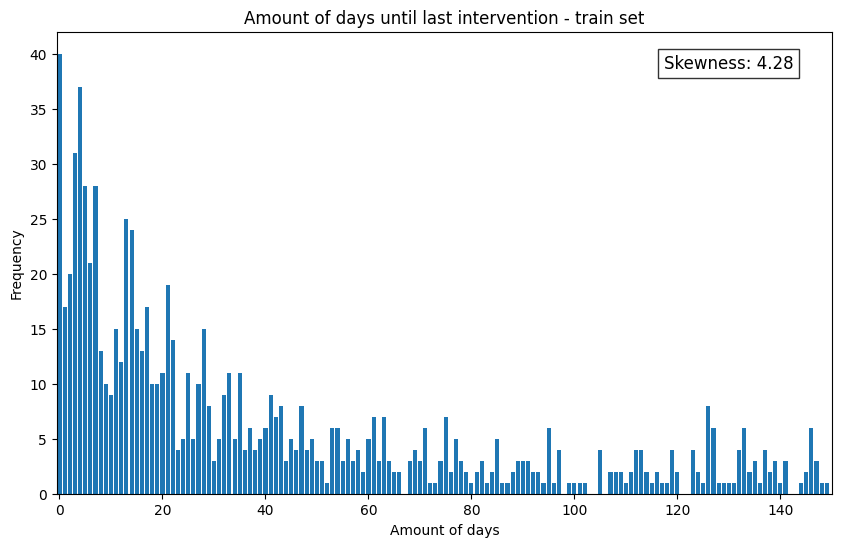

In [30]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(No_days_frequencies_train.index, No_days_frequencies_train)

# Add skewness to the plot
plt.text(0.95, 0.95, f'Skewness: {skew(train['No_days'], nan_policy='omit'):.2f}', transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8))

# Add labels and title
plt.xlabel('Amount of days')
plt.ylabel('Frequency')
plt.title('Amount of days until last intervention - train set')
ax = plt.gca()
ax.set_xlim([-0.5, 150])

# Show the plot
plt.savefig('../visualizations/eda_png/days.png', bbox_inches='tight')
plt.show()